# データの学習

Pytorch で深層学習モデルを構築し、データを学習・評価する．

In [47]:
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
def show_results(train_losses, test_losses, train_accs, test_accs):
    print('Train loss:', train_losses[-1])
    print('Test loss:', test_losses[-1])
    print('Train accuracy:', train_accs[-1])
    print('Test accuracy:', test_accs[-1])

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].plot(train_losses, label='train')
    ax[0].plot(test_losses, label='test')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[1].plot(train_accs, label='train')
    ax[1].plot(test_accs, label='test')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    plt.show()

In [49]:
class AquatanBleDataset(torch.utils.data.Dataset):
    def __init__(self, data_paths: list[str], n_samples: int):
        df = pd.concat([pd.read_csv(path).sample(n=n_samples) for path in data_paths])
        self.X = torch.tensor(df.drop(columns=["label"]).values, dtype=torch.float32)
        self.t = torch.tensor(pd.get_dummies(df["label"]).values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.t[idx]


In [50]:
# 深層学習モデルの定義
INPUT_DIM = 7
OUTPUT_DIM = 2
HIDDEN_DIM = 10
class AquaBleClassifier(nn.Module):
    def __init__(self):
        super(AquaBleClassifier, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.SiLU(),
            nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

Train loss: 0.0010554488168822394
Test loss: 0.0002689126133918762
Train accuracy: 0.9972222222222222
Test accuracy: 0.9891666666666666


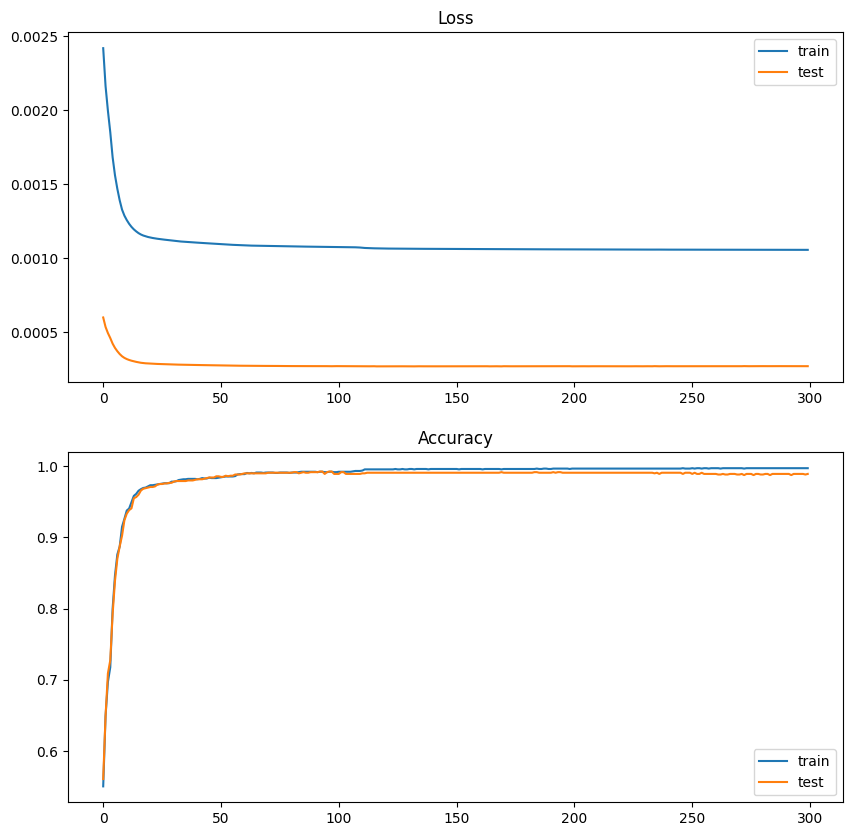

In [55]:
DIRECTORY = "../formatted_w"
LABELS = ["8302", "8303"]
TIME_WINDOW = 60

DATA_SIZE = 1500
TRAIN_RATIO = 0.6
BATCH_SIZE = 300
EPOCHS = 300

# データの読み込み
data_paths = [f"{DIRECTORY}/{label}_t={TIME_WINDOW}.csv" for label in LABELS]
dataset = AquatanBleDataset(data_paths, DATA_SIZE)

# トレインデータとテストデータに分割
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [TRAIN_RATIO, 1-TRAIN_RATIO])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# モデルの定義
model = AquaBleClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# 学習
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(EPOCHS):
    model.train()
    # ミニバッチ学習
    for x, t in train_loader:
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, t)
        loss.backward()
        optimizer.step()

    # トレインデータでの評価
    model.eval()
    train_loss = 0
    train_acc = 0
    for x, t in train_loader:
        y = model(x)
        loss = criterion(y, t)
        train_loss += loss.item()
        argmax_y = torch.argmax(y, dim=1)
        argmax_t = torch.argmax(t, dim=1)
        train_acc += torch.sum(argmax_y == argmax_t).item()
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    # テストデータでの評価
    test_loss = 0
    test_acc = 0
    for x, t in test_loader:
        y = model(x)
        loss = criterion(y, t)
        test_loss += loss.item()
        argmax_y = torch.argmax(y, dim=1)
        argmax_t = torch.argmax(t, dim=1)
        test_acc += torch.sum(argmax_y == argmax_t).item()
    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# 最終結果の表示
show_results(train_losses, test_losses, train_accs, test_accs)


In [78]:
# モデルの出力を確認
DATA_SIZE = 10
model.eval()
dataset = AquatanBleDataset(data_paths, DATA_SIZE)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
x, t = next(iter(data_loader))
y = model(x)
argmax_y = torch.argmax(y, dim=1)
argmax_t = torch.argmax(t, dim=1)
df = pd.DataFrame({
    "True": argmax_t.numpy(),
    "Predict": argmax_y.numpy()
})
pd.concat([pd.DataFrame(x.numpy()), df, pd.DataFrame(y.detach().numpy())], axis=1)

,0,1,2,3,4,5,6,True,Predict,0,1
0,26.224701,19.166866,100.000000,70.794601,100.000000,100.0,100.000000,0,0,1.000000e+00,6.125074e-12
1,17.289766,11.836727,45.466042,10.070600,41.243000,100.0,100.000000,0,0,1.000000e+00,3.428102e-10
2,14.040600,8.263528,39.810699,13.304912,31.033382,100.0,100.000000,0,0,1.000000e+00,5.274211e-10
3,11.730303,7.127338,33.552052,10.863100,8.081741,100.0,66.945152,0,0,9.999979e-01,2.203645e-06
4,20.599421,18.234880,100.000000,100.000000,28.183800,100.0,100.000000,0,0,9.999999e-01,1.354467e-07
5,22.339600,7.339361,71.247253,23.526615,22.387199,100.0,56.234100,0,0,9.999630e-01,3.694113e-05
6,14.771712,9.862988,33.557068,12.255436,10.750905,100.0,100.000000,0,0,1.000000e+00,1.451291e-08
7,21.445986,11.293404,79.959846,35.481300,66.463600,100.0,100.000000,0,0,1.000000e+00,1.363666e-11
8,9.877585,18.670206,100.000000,11.220200,35.481300,100.0,100.000000,0,0,1.000000e+00,1.116819e-09
9,25.525534,6.333493,19.952600,6.990535,33.442665,100.0,35.481300,0,1,3.433108e-01,6.566892e-01


In [53]:
# モデルの保存
OUTPUT_FILE = f"../model/model_t={TIME_WINDOW}.pth"
torch.save(model.state_dict(), OUTPUT_FILE)